Projet : Accident de la route
==============

## Etape 3 : Modélisation

### Import des données

In [1]:
# import des librairies
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.max_info_columns

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lazypredict.supervised import LazyClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix,classification_report, f1_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import du dataset
df = pd.read_csv("dataset/dataset_final.csv")
df.head()

,place,catu,grav,sexe,trajet,secu1,locp,catr,circ,nbv,vosp,prof,plan,surf,infra,situ,vma,lum,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor,age_group,h_group,weekday
0,1,1,1,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.56,4.73,1,3,0,2,1,9,1,2,6,2
1,1,1,0,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.56,4.73,1,6,0,2,2,1,1,7,6,2
2,1,1,1,1,9,1,0,4,2,2,0,1,1,1,0,1,50,1,25204,2,3,1,3,46.93,6.35,2,6,0,2,8,15,1,4,3,3
3,1,1,0,1,4,1,0,4,2,2,0,1,1,1,0,1,50,1,25204,2,3,1,3,46.93,6.35,2,5,0,2,1,1,1,6,3,3
4,1,1,0,1,0,1,-1,3,-1,2,0,1,1,1,5,1,50,1,22360,2,6,1,2,48.49,-2.76,2,6,0,2,1,2,1,3,6,3


### Séparation des données

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(["grav"], axis=1), df.grav, test_size=0.3)
print("Séparation des labels et targets :", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Séparation des labels et targets : (319499, 34) (136929, 34) (319499,) (136929,)


### Standardisation

In [4]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Choisir la meilleure sélection de variables

In [39]:
best_f1_score_lr = 0
best_k_lr = 0

for k in range(1, X_train_scaled.shape[1] + 1):
    select_k_best_lr = SelectKBest(score_func=f_classif, k=k)
    
    X_train_k_best_lr = select_k_best_lr.fit_transform(X_train_scaled, y_train)
    X_test_k_best_lr = select_k_best_lr.transform(X_test_scaled)
    
    model_k_lr = OneVsRestClassifier(LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000))
    model_k_lr.fit(X_train_k_best_lr, y_train)
    
    y_pred_k_lr = model_k_lr.predict(X_test_k_best_lr)
    f1_k_lr = f1_score(y_test, y_pred_k_lr, average='weighted')
    
    if f1_k_lr > best_f1_score_lr:
        best_f1_score_lr = f1_k_lr
        best_k_lr = k

print("Meilleur nombre de variables :", best_k_lr)
print("Meilleur F1 score:", best_f1_score_lr)

Meilleur nombre de variables : 32
Meilleur F1 score: 0.7409953911273341


#### Application de la meilleure sélection de features

In [24]:
selector = SelectKBest(f_classif, k=best_k_lr)

X_train_kb = selector.fit_transform(X_train_scaled, y_train)
X_test_kb = selector.transform(X_test_scaled)

print(X_train_kb.shape, X_test_kb.shape)

(319499, 32) (136929, 32)


### Choix des modèles

[LightGBM] [Info] Number of positive: 185996, number of negative: 133503
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 319499, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582149 -> initscore=0.331601
[LightGBM] [Info] Start training from score 0.331601
Matrice de confusion :
 [[44338 12611]
 [13742 66238]]


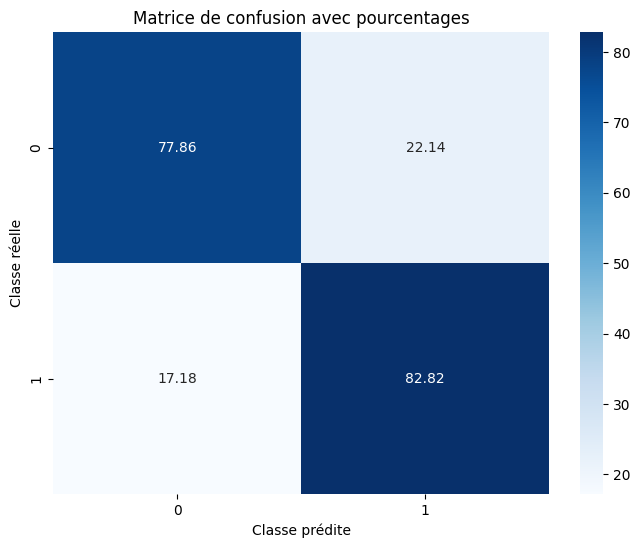

In [5]:
from lightgbm import LGBMClassifier

model_test = LGBMClassifier(random_state=42)
model_test.fit(X_train_scaled, y_train)
y_pred_test = model_test.predict(X_test_scaled)

cm_lr_test = confusion_matrix(y_test, y_pred_test)
print("Matrice de confusion :\n", cm_lr_test)

row_sums_lr_test = cm_lr_test.sum(axis = 1)
cm_percent_lr_test = (cm_lr_test.T / row_sums_lr_test).T * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_lr_test, annot = True, fmt = ".2f", cmap = "Blues")
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion avec pourcentages')
plt.show()

### LGBMClassifier

In [38]:
hp_lgbm = {
#    'learning_rate': [0.01, 0.1, 1.0],                # Taux d'apprentissage
    'n_estimators': [50, 70,100],                  # Nombre d'estimateurs
    'metric': ['aucpr'],
    'objective': ['binary'],
    'num_leaves': [50, 60, 70, 80],                       # Nombre maximum de feuilles par arbre
    'boosting_type': ['gbdt', 'dart']#,        # Type de boosting
#    'subsample': [0.8, 1.0],                          # Sous-échantillonnage des données
#    'colsample_bytree': [0.8, 1.0]                   # Fraction de colonnes à utiliser par arbre
            }

In [109]:
gs_lgbm = GridSearchCV(estimator=LGBMClassifier(n_iter=1000),
                           param_grid= hp_lgbm,
                           
                         #  cv=3,  # Nombre de folds pour la validation croisée
                           verbose=True,
                           return_train_score=True,
                            refit=True,
                            scoring='average_precision',
                           n_jobs=-1)  # Utiliser tous les coeurs du CPU

In [39]:
import lightgbm as lgb

X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train_scaled, y_train, test_size=0.3, random_state=42)

fit_params = {
    "eval_set": [(X_val, y_val)],
    "eval_metric": 'logloss'
}

gs_lgbm = GridSearchCV(estimator=LGBMClassifier(n_iter=1000), 
                       param_grid=hp_lgbm, 
                       verbose=True,
                           return_train_score=True,
                            refit=True,
                            scoring='f1',
                            n_jobs=-1,
                       cv=3)

gs_lgbm.fit(X_train_sub, y_train_sub, **fit_params, 
            callbacks=[lgb.early_stopping(stopping_rounds=3)]
            )

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/yu/workspace/a

[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Number of positive: 86902, number of negative:

/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.835104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.401299


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.848104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490
Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.401081


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
Training until validation scores don't improve for 3 rounds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.512335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[119]	valid_0's binary_logloss: 0.401077


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.866822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.400461


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.858622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.400603


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.717100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.400036


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.730819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.40017


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.867587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.398958


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.788352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 0.399534


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.829289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 0.398803
Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 0.399142


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.938938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.649872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] 

/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.848408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.401081


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.807473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.401299


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.977137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[119]	valid_0's binary_logloss: 0.401077


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.001326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.400461


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.794086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.400603


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.897990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.398958


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.840709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.400905


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.891631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.400036


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.857954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.401081


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.777381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 0.398803
Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 0.399534


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.737173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.828944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490
Training until validation scores don't improve for 3 rounds
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[119]	valid_0's binary_logloss: 0.401077


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.828658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.400461


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.829413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.40017


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.846930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.401299


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.748094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 0.399142


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.817628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.400603


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Number of positive: 86902, number of negative: 62196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.738084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 149098, number of used features: 33
[LightGBM] [Warning] num_iterations is set=1000, n_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582852 -> initscore=0.334490
[LightGBM] [Info] Start training from score 0.334490


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


KeyboardInterrupt: 

In [ ]:
best_hp_lgbm = gs_lgbm.best_params_
best_score_lgbm = gs_lgbm.best_score_
best_estimator_lgbm = gs_lgbm.best_estimator_

print("Meilleurs paramètres trouvés:", best_hp_lgbm)
print("Meilleur score de validation croisée:", best_score_lgbm)

Meilleurs paramètres trouvés: {'boosting_type': 'dart', 'metric': 'aucpr', 'n_estimators': 50, 'num_leaves': 80, 'objective': 'binary'}
Meilleur score de validation croisée: 0.8133369693569837


In [ ]:
y_pred_lgbm = best_estimator_lgbm.predict(X_test_scaled)

cv_results_lgbm = gs_lgbm.cv_results_

#### Matrice de confusion de lgbm classifier

Matrice de confusion :
 [[44823 12263]
 [12834 67009]]


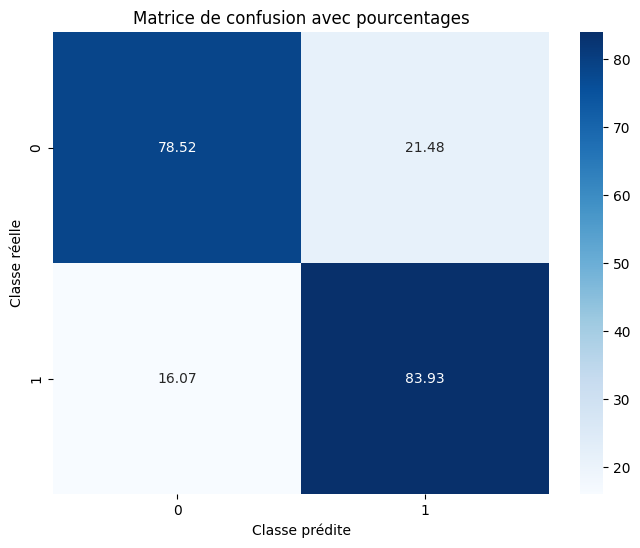

In [113]:
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
print("Matrice de confusion :\n", cm_lgbm)

row_sums_lgbm = cm_lgbm.sum(axis = 1)
cm_percent_lgbm = (cm_lgbm.T / row_sums_lgbm).T * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_lgbm, annot = True, fmt = ".2f", cmap = "Blues")
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion avec pourcentages')
plt.show()

In [122]:
test_indices = df.index.isin(X_test_scaled)  
df_test = df.loc[test_indices].copy()

df_test['grav'] = y_test
df_test['Pred'] = y_pred_lgbm

df_test


ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

In [134]:
df_filtered = df.iloc[:len(y_test)]  

df_filtered['pred_lgbm'] = y_pred_lgbm
df_filtered

,place,catu,grav,sexe,trajet,secu1,locp,catr,circ,nbv,vosp,prof,plan,surf,infra,situ,vma,lum,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor,age_group,h_group,weekday,pred_lgbm
0,1,1,2,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.56,4.73,1,3,0,2,1,9,1,2,6,2,2
1,1,1,1,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.56,4.73,1,6,0,2,2,1,1,7,6,2,1
2,1,1,2,1,9,1,0,4,2,2,0,1,1,1,0,1,50,1,25204,2,3,1,3,46.93,6.35,2,6,0,2,8,15,1,4,3,3,2
3,1,1,1,1,4,1,0,4,2,2,0,1,1,1,0,1,50,1,25204,2,3,1,3,46.93,6.35,2,5,0,2,1,1,1,6,3,3,2
4,1,1,1,1,0,1,-1,3,-1,2,0,1,1,1,5,1,50,1,22360,2,6,1,2,48.49,-2.76,2,6,0,2,1,2,1,3,6,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136924,7,2,1,2,5,1,0,1,3,4,0,1,2,2,0,1,110,3,34114,1,1,2,2,43.64,3.57,1,6,0,0,4,1,1,1,3,6,1
136925,8,2,1,2,5,1,0,1,3,4,0,1,2,2,0,1,110,3,34114,1,1,2,2,43.64,3.57,1,6,0,0,4,1,1,1,3,6,1
136926,9,2,1,2,5,1,0,1,3,4,0,1,2,2,0,1,110,3,34114,1,1,2,2,43.64,3.57,1,6,0,0,4,1,1,1,3,6,1
136927,2,2,2,2,5,1,0,1,3,4,0,1,2,2,0,1,110,3,34114,1,1,2,2,43.64,3.57,1,6,0,0,4,1,1,7,3,6,1


In [136]:
df_mismatch = df_filtered[df_filtered['grav'] != df_filtered['pred_lgbm']]
df_mismatch

,place,catu,grav,sexe,trajet,secu1,locp,catr,circ,nbv,vosp,prof,plan,surf,infra,situ,vma,lum,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor,age_group,h_group,weekday,pred_lgbm
3,1,1,1,1,4,1,0,4,2,2,0,1,1,1,0,1,50,1,25204,2,3,1,3,46.93,6.35,2,5,0,2,1,1,1,6,3,3,2
4,1,1,1,1,0,1,-1,3,-1,2,0,1,1,1,5,1,50,1,22360,2,6,1,2,48.49,-2.76,2,6,0,2,1,2,1,3,6,3,2
5,1,1,2,2,9,1,-1,3,-1,2,0,1,1,1,5,1,50,1,22360,2,6,1,2,48.49,-2.76,1,6,0,2,4,2,1,4,6,3,1
6,1,1,1,2,0,1,-1,4,1,1,0,2,1,1,0,1,30,1,16102,2,3,8,6,45.69,-0.33,2,6,0,1,3,16,1,3,6,3,2
7,10,3,2,2,5,2,1,4,1,1,0,2,1,1,0,1,30,1,16102,2,3,8,6,45.69,-0.33,2,6,0,1,3,16,1,6,6,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136920,1,1,2,2,5,1,0,3,1,2,0,1,1,1,0,1,90,1,86070,1,3,1,3,46.57,0.73,2,6,0,0,8,15,1,5,4,5,1
136921,1,1,2,1,0,1,0,7,2,2,0,1,3,2,0,3,70,5,59088,1,1,1,6,50.65,2.88,3,6,6,0,1,14,1,3,1,6,1
136922,1,1,1,1,5,1,0,1,3,4,0,1,2,2,0,1,110,3,34114,1,1,2,2,43.64,3.57,1,6,0,2,1,0,1,3,3,6,2
136927,2,2,2,2,5,1,0,1,3,4,0,1,2,2,0,1,110,3,34114,1,1,2,2,43.64,3.57,1,6,0,0,4,1,1,7,3,6,1


In [158]:
df_mismatch.lum.value_counts()

lum
 1    45942
 5     9273
 3     6263
 2     4683
 4      530
-1        1
Name: count, dtype: int64

In [159]:
df_filtered.lum.value_counts()

lum
 1    93804
 5    19091
 3    13142
 2     9812
 4     1077
-1        3
Name: count, dtype: int64